# Preparación de los datos

In [1]:
import os
import numpy as np
import pandas as pd
import chardet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))


In [2]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Anio2017.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [3]:
# Se obtienen los datos de 2017
df_acoustics = pd.read_csv('data/raw/Anio2017.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


370

In [4]:
# Se les concatenan los datos del resto de años de los csv
for year in range(2018, 2024):
    path = 'data/raw/Anio' + str(year) + '.csv'
    df = pd.read_csv(path, encoding=result['encoding'], delimiter=';')
    df_acoustics = pd.concat([df_acoustics, df])

len(df_acoustics)


2292

In [5]:
# Se le concatenan, ahora, los datos del resto de años de los xls
# Se parte de 2012 porque en 2011 faltan 5 zonas
month_dict = {'ene': '01',
                'feb': '02',
                'mar': '03',
                'abr': '04',
                'may': '05',
                'jun': '06',
                'jul': '07',
                'ago': '08',
                'sep': '09',
                'oct': '10',
                'nov': '11',
                'dic': '12'
                }

skiprows = 3

for year in range(2012, 2017):
    path = 'data/raw/anio' + str(year) + '.xls'
    if year == 2015:
        month_dict_2015 = month_dict.copy()
        month_dict_2015.pop('jun')
        month_dict_2015.pop('jul')
        for sheet in range(10):
            df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
            df_xls['Fecha'] = list(month_dict_2015.keys())[sheet] + '-' + str(year)[2:]
            df_acoustics = pd.concat([df_acoustics, df_xls])
    else:
        if year == 2014:
            skiprows += 1
        for sheet in range(12):
            df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
            df_xls['Fecha'] = list(month_dict.keys())[sheet] + '-' + str(year)[2:]
            df_acoustics = pd.concat([df_acoustics, df_xls])

df_acoustics = df_acoustics.reset_index(drop=True)

len(df_acoustics)


C:\Users\Roger\AppData\Local\Temp\ipykernel_11908\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
C:\Users\Roger\AppData\Local\Temp\ipykernel_11908\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
C:\Users\Roger\AppData\Local\Temp\ipykernel_11908\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_xls = pd.read_excel(path, sheet_name=sheet, skiprows=skiprows, usecols=range(1, 12))
C:\Users\Roger\AppData\Local\Temp\ipykernel_11908\1082118438.py:33: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a

4193

In [6]:
# Se elimina la columna "Unnamed"
df_acoustics = df_acoustics.drop(columns='Unnamed: 3')

df_acoustics.head()


,Fecha,NMT,Situación,Ld,Le,Ln,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99,Nombre,LAeq,L1,L10,L50,L90,L99
0,ene-17,1,Paseo de Recoletos,"69,1","69,2","66,5","68,2",74,"71,3","65,8","57,9",50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ene-17,2,Carlos V,"70,2","69,8","66,9","69,3","75,5","71,4","67,9","61,2","54,8",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ene-17,3,Plaza del Carmen,"67,7","60,9","62,8","65,8","75,4",66,"58,5","53,4","50,7",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ene-17,4,Plaza de España,"65,9","65,9","62,4",65,"72,7","67,4","63,5","56,4","49,1",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ene-17,5,Barrio del Pilar,"65,7","66,2","60,1","64,6","74,4",67,"59,7","46,9","37,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Se fusionan las columnas "Nombre" y "Situación", que son la misma cosa
df_acoustics['Situación'] = df_acoustics['Situación'].fillna(df_acoustics['Nombre'])
df_acoustics = df_acoustics.drop(columns='Nombre')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   Ld         2912 non-null   object
 4   Le         2912 non-null   object
 5   Ln         2912 non-null   object
 6   LAeq24     3344 non-null   object
 7   LAS01      3342 non-null   object
 8   LAS10      3342 non-null   object
 9   LAS50      3342 non-null   object
 10  LAS90      3342 non-null   object
 11  LAS99      3342 non-null   object
 12  LAeq       728 non-null    object
 13  L1         728 non-null    object
 14  L10        728 non-null    object
 15  L50        728 non-null    object
 16  L90        728 non-null    object
 17  L99        728 non-null    object
dtypes: object(18)
memory usage: 589.8+ KB


In [8]:
# Se fusionan las demás columnas con datos comunes
for tuple in [('LAeq24', 'LAeq'), ('LAS01', 'L1'), ('LAS10', 'L10'), ('LAS50', 'L50'), ('LAS90', 'L90'), ('LAS99', 'L99')]:
    df_acoustics[tuple[0]] = df_acoustics[tuple[0]].fillna(df_acoustics[tuple[1]])

df_acoustics = df_acoustics.drop(columns=['LAeq', 'L1', 'L10', 'L50', 'L90', 'L99'])

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   Ld         2912 non-null   object
 4   Le         2912 non-null   object
 5   Ln         2912 non-null   object
 6   LAeq24     4072 non-null   object
 7   LAS01      4070 non-null   object
 8   LAS10      4070 non-null   object
 9   LAS50      4070 non-null   object
 10  LAS90      4070 non-null   object
 11  LAS99      4070 non-null   object
dtypes: object(12)
memory usage: 393.2+ KB


In [9]:
# Se borran las columnas con datos de mañana, día y noche, pues no existen para todos los años
df_acoustics = df_acoustics.drop(columns=['Ld', 'Le', 'Ln'])

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4070 non-null   object
 5   LAS10      4070 non-null   object
 6   LAS50      4070 non-null   object
 7   LAS90      4070 non-null   object
 8   LAS99      4070 non-null   object
dtypes: object(9)
memory usage: 294.9+ KB


In [10]:
# Se buscan los valores donde las "LAS" son nulos pero "LAeq" no
df_acoustics[df_acoustics['LAS50'].isna() & df_acoustics['Situación'].notna()]


,Fecha,NMT,Situación,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99
4143,nov-16,16,Arturo Soria,61.5,NaN,NaN,NaN,NaN,NaN
4147,nov-16,20,Avda de Moratalaz,62.1,NaN,NaN,NaN,NaN,NaN


In [11]:
# Se busca el mes anterior a ese punto
df_acoustics[((df_acoustics['Situación'] == 'Arturo Soria') | (df_acoustics['Situación'] == 'Avda de Moratalaz'))
                & (df_acoustics['Fecha'] == 'oct-16')
              ]


,Fecha,NMT,Situación,LAeq24,LAS01,LAS10,LAS50,LAS90,LAS99
4112,oct-16,16,Arturo Soria,60.8,67.8,64.5,58.6,42.7,37.1
4116,oct-16,20,Avda de Moratalaz,61.6,70.8,64.2,58.0,44.8,36.1


In [12]:
# Se imputan esos nulos al mes anterior
for col, values in [('LAS01', [67.8, 70.8]), ('LAS10', [64.5, 64.2]), ('LAS50', [58.6, 58.0]), ('LAS90', [42.7, 44.8]), ('LAS99', [37.1, 36.1])]:
    fill_dict =  {4143: values[0], 4147: values[1]}
    df_acoustics[col] = df_acoustics[col].fillna(value=fill_dict)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4193 non-null   object
 1   NMT        4112 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4072 non-null   object
 5   LAS10      4072 non-null   object
 6   LAS50      4072 non-null   object
 7   LAS90      4072 non-null   object
 8   LAS99      4072 non-null   object
dtypes: object(9)
memory usage: 294.9+ KB


In [13]:
# Se borran los demás nulos, pues son errores de la conversion de los xls
# Todavía existen nulos, pero no son fallos de conversión y están en formato "string"
df_acoustics = df_acoustics.dropna()

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4072 entries, 0 to 4192
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      4072 non-null   object
 1   NMT        4072 non-null   object
 2   Situación  4072 non-null   object
 3   LAeq24     4072 non-null   object
 4   LAS01      4072 non-null   object
 5   LAS10      4072 non-null   object
 6   LAS50      4072 non-null   object
 7   LAS90      4072 non-null   object
 8   LAS99      4072 non-null   object
dtypes: object(9)
memory usage: 318.1+ KB


In [14]:
# Se añaden los meses faltantes del año 15 con nulos. Se imputarán más adelante
for month in ['jun-15', 'jul-15']:
    df_summer_15 = df_acoustics[df_acoustics['Fecha'] == 'ago-15'].copy()
    df_summer_15[['LAeq24', 'LAS01', 'LAS10', 'LAS50', 'LAS90', 'LAS99', 'NMT']] = np.nan
    df_summer_15['Fecha'] = month
    df_acoustics = pd.concat([df_acoustics, df_summer_15])


In [15]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['Fecha'] = df_acoustics['Fecha'].str.split('-').apply(lambda x: f'{month_dict[x[0]]}-{x[1]}')
df_acoustics['Fecha'] = pd.to_datetime(df_acoustics['Fecha'], format='%m-%y')

df_acoustics = df_acoustics.rename(columns={'Fecha': 'mes'})

df_acoustics = df_acoustics.set_index('mes')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01', '2012-01-01', '2012-01-01',
               '2012-01-01', '2012-01-01',
               ...
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01', '2023-02-01', '2023-02-01',
               '2023-02-01', '2023-02-01'],
              dtype='datetime64[ns]', name='mes', length=4134, freq=None)

In [16]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics = df_acoustics.astype(str)

for col in df_acoustics.columns[2:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = df_acoustics[col].apply(lambda x: float(x) if x != 'N/D' else np.nan)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4134 entries, 2012-01-01 to 2023-02-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NMT        4134 non-null   object 
 1   Situación  4134 non-null   object 
 2   LAeq24     4019 non-null   float64
 3   LAS01      4005 non-null   float64
 4   LAS10      4005 non-null   float64
 5   LAS50      4005 non-null   float64
 6   LAS90      4005 non-null   float64
 7   LAS99      4005 non-null   float64
dtypes: float64(6), object(2)
memory usage: 290.7+ KB


In [17]:
# Se cambian los nombres de las columnas para mayor claridad
df_acoustics = df_acoustics.rename(columns={'NMT': 'num_medidas',
                                          'Situación': 'zonas',
                                            'LAeq24': 'sonido_24_h',
                                            'LAS01': 'sonido_superado_1%',
                                            'LAS10': 'sonido_superado_10%',
                                            'LAS50': 'sonido_superado_50%',
                                            'LAS90': 'sonido_superado_90%',
                                            'LAS99': 'sonido_superado_99%'
                                            }
                                    )                   

df_acoustics.head()


,num_medidas,zonas,sonido_24_h,sonido_superado_1%,sonido_superado_10%,sonido_superado_50%,sonido_superado_90%,sonido_superado_99%
mes,,,,,,,,
2012-01-01,1,Paseo de Recoletos,68.7,74.9,72.0,66.5,59.1,51.0
2012-01-01,86,Tres Olivos,58.1,66.9,61.2,52.0,39.3,36.6
2012-01-01,55,Urbanización Embajada II,55.9,63.5,58.1,51.1,44.3,41.3
2012-01-01,50,Pza de Castilla,66.8,72.8,68.4,64.9,58.3,50.8
2012-01-01,48,Castellana,63.9,69.3,66.5,62.5,54.8,46.1


In [18]:
# Se pivota la tabla para que cada columna sea una zona y los valores sean el valor que supera los que hay el 50% del tiempo 
# Así podemos decir que la mayoría del tiempo se supera tal o cual valor
df_acoustics = df_acoustics.pivot_table(index='mes', columns='zonas', values='sonido_superado_50%')

df_acoustics.head()


zonas,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.9,59.7,59.1,54.5,59.9,57.5,NaN,46.5,62.5,60.9,...,64.9,58.1,64.9,66.5,55.1,NaN,52.0,51.1,53.8,52.2
2012-02-01,57.6,59.4,58.8,54.6,59.4,58.0,NaN,47.5,62.2,61.6,...,64.2,57.8,64.6,66.5,54.5,NaN,51.8,51.2,54.2,52.2
2012-03-01,57.5,59.0,58.3,53.7,59.1,57.4,NaN,48.2,62.1,60.8,...,64.1,58.5,64.1,66.0,53.2,NaN,51.9,50.3,53.7,52.6
2012-04-01,57.7,59.0,58.5,53.1,58.7,56.6,NaN,46.6,62.1,60.3,...,63.8,58.6,64.5,65.7,54.0,NaN,52.6,50.4,53.4,52.9
2012-05-01,57.2,58.4,58.1,53.5,59.3,57.1,NaN,46.8,61.5,60.6,...,63.9,59.5,63.9,65.7,53.2,NaN,52.9,50.6,54.0,54.3


In [19]:
# Plaza de España tiene muchos nulos
df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2012-01-01 to 2023-02-01
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          131 non-null    float64
 1   Arturo Soria              130 non-null    float64
 2   Avda de Moratalaz         132 non-null    float64
 3   Barajas Pueblo            132 non-null    float64
 4   Barrio del Pilar          132 non-null    float64
 5   Campo de las Naciones     132 non-null    float64
 6   Carlos V                  125 non-null    float64
 7   Casa de Campo             132 non-null    float64
 8   Castellana                131 non-null    float64
 9   Cuatro Caminos            131 non-null    float64
 10  Cuatro Vientos            132 non-null    float64
 11  El Pardo                  132 non-null    float64
 12  Embajada                  130 non-null    float64
 13  Ensanche de Vallecas      126 non-null    floa

In [20]:
# Se establece la frecuencia "MS" ("month start") y se interpolan los nulos
df_acoustics = df_acoustics.asfreq('MS')

df_acoustics = df_acoustics.apply(lambda x: x.interpolate(method='linear'))

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  129 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

In [21]:
# Hay algunos valores que se resisten a ser imputados por ser los primeros. Se atribuyen al más cercano
df_acoustics.loc[df_acoustics['Carlos V'].isna(), 'Carlos V'] = 67.8
df_acoustics.loc[df_acoustics['Gregorio Marañón'].isna(), 'Gregorio Marañón'] = 66.0
df_acoustics.loc[df_acoustics['Santa Eugenia'].isna(), 'Santa Eugenia'] = 61.8

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 2012-01-01 to 2023-02-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          134 non-null    float64
 1   Arturo Soria              134 non-null    float64
 2   Avda de Moratalaz         134 non-null    float64
 3   Barajas Pueblo            134 non-null    float64
 4   Barrio del Pilar          134 non-null    float64
 5   Campo de las Naciones     134 non-null    float64
 6   Carlos V                  134 non-null    float64
 7   Casa de Campo             134 non-null    float64
 8   Castellana                134 non-null    float64
 9   Cuatro Caminos            134 non-null    float64
 10  Cuatro Vientos            134 non-null    float64
 11  El Pardo                  134 non-null    float64
 12  Embajada                  134 non-null    float64
 13  Ensanche de Vallecas      134 non-nul

### Guardado df_acoustics

In [22]:
df_acoustics.to_csv('data/processed/acoustics.csv')

df_acoustics.head()


zonas,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.9,59.7,59.1,54.5,59.9,57.5,67.8,46.5,62.5,60.9,...,64.9,58.1,64.9,66.5,55.1,61.8,52.0,51.1,53.8,52.2
2012-02-01,57.6,59.4,58.8,54.6,59.4,58.0,67.8,47.5,62.2,61.6,...,64.2,57.8,64.6,66.5,54.5,61.8,51.8,51.2,54.2,52.2
2012-03-01,57.5,59.0,58.3,53.7,59.1,57.4,67.8,48.2,62.1,60.8,...,64.1,58.5,64.1,66.0,53.2,61.8,51.9,50.3,53.7,52.6
2012-04-01,57.7,59.0,58.5,53.1,58.7,56.6,67.8,46.6,62.1,60.3,...,63.8,58.6,64.5,65.7,54.0,61.8,52.6,50.4,53.4,52.9
2012-05-01,57.2,58.4,58.1,53.5,59.3,57.1,67.8,46.8,61.5,60.6,...,63.9,59.5,63.9,65.7,53.2,61.8,52.9,50.6,54.0,54.3


In [23]:
df_acoustics = pd.read_csv('data/processed/acoustics.csv', parse_dates=['mes'], index_col='mes')
df_acoustics = df_acoustics.asfreq('MS')

df_acoustics.head()


,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,57.9,59.7,59.1,54.5,59.9,57.5,67.8,46.5,62.5,60.9,...,64.9,58.1,64.9,66.5,55.1,61.8,52.0,51.1,53.8,52.2
2012-02-01,57.6,59.4,58.8,54.6,59.4,58.0,67.8,47.5,62.2,61.6,...,64.2,57.8,64.6,66.5,54.5,61.8,51.8,51.2,54.2,52.2
2012-03-01,57.5,59.0,58.3,53.7,59.1,57.4,67.8,48.2,62.1,60.8,...,64.1,58.5,64.1,66.0,53.2,61.8,51.9,50.3,53.7,52.6
2012-04-01,57.7,59.0,58.5,53.1,58.7,56.6,67.8,46.6,62.1,60.3,...,63.8,58.6,64.5,65.7,54.0,61.8,52.6,50.4,53.4,52.9
2012-05-01,57.2,58.4,58.1,53.5,59.3,57.1,67.8,46.8,61.5,60.6,...,63.9,59.5,63.9,65.7,53.2,61.8,52.9,50.6,54.0,54.3


# Análisis de estacionalidad y estacionaridad

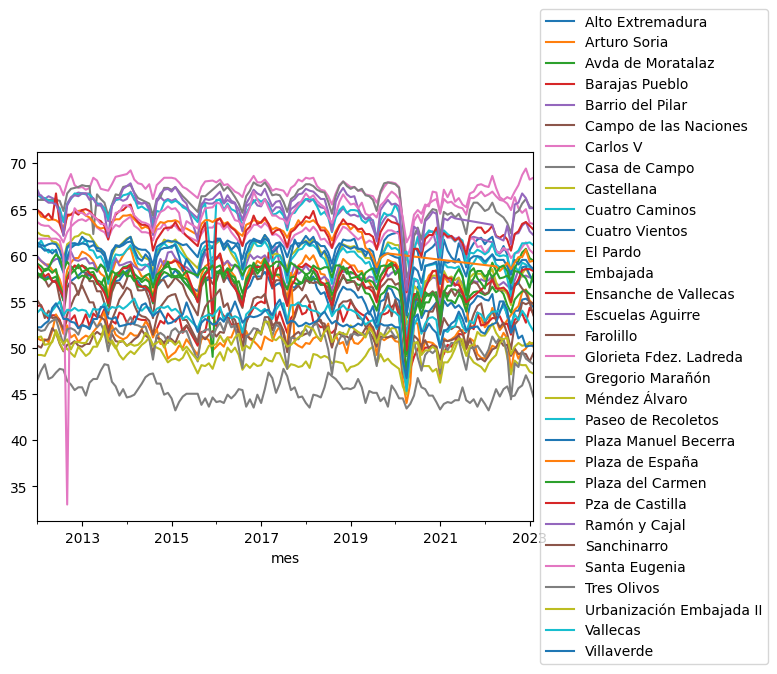

In [24]:
# Todas las zonas. Se percibe que la estacionalidad puede ser aditiva
df_acoustics.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


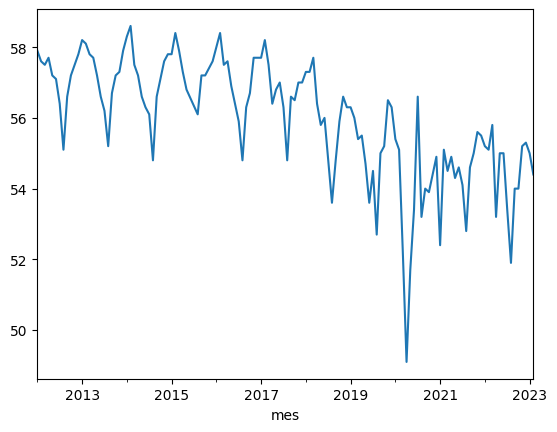

In [25]:
# Solo el primero
df_acoustics['Alto Extremadura'].plot()
plt.show()


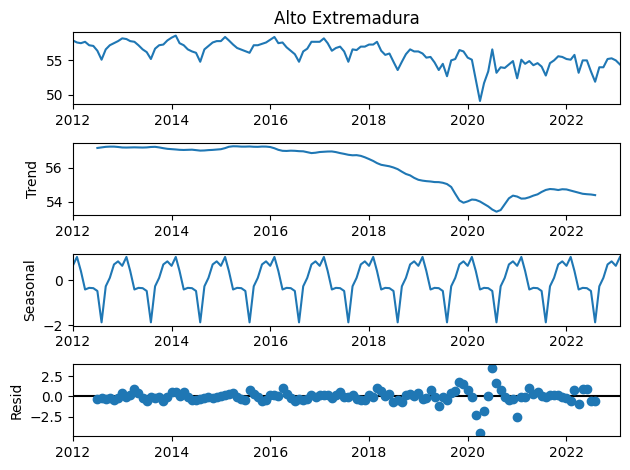

In [26]:
# Descomposición estacional del primero. La estacionalidad es clara
sm.tsa.seasonal_decompose(df_acoustics['Alto Extremadura'], model="additive", period=12).plot()
plt.show()


In [27]:
# Las zonas no son estacionarias
p_values = dict()
for zona in df_acoustics.columns:
    dickey_fuller = sts.adfuller(df_acoustics[zona])
    p_value = dickey_fuller[1]
    p_values[zona] = p_value
    if p_value > 0.05:
        print(f'La zona de {zona} no es estacionaria (p valor = {p_value})')


La zona de Alto Extremadura no es estacionaria (p valor = 0.9154044813456497)
La zona de Arturo Soria no es estacionaria (p valor = 0.7958608838409755)
La zona de Avda de Moratalaz no es estacionaria (p valor = 0.8130201768006494)
La zona de Barrio del Pilar no es estacionaria (p valor = 0.615021709323205)
La zona de Campo de las Naciones no es estacionaria (p valor = 0.27036291208420343)
La zona de Carlos V no es estacionaria (p valor = 0.868869406562577)
La zona de Casa de Campo no es estacionaria (p valor = 0.14112227739647426)
La zona de Castellana no es estacionaria (p valor = 0.825989710224537)
La zona de Cuatro Caminos no es estacionaria (p valor = 0.6235118156073408)
La zona de Cuatro Vientos no es estacionaria (p valor = 0.3399343525609905)
La zona de Ensanche de Vallecas no es estacionaria (p valor = 0.29404199505177514)
La zona de Escuelas Aguirre no es estacionaria (p valor = 0.8890834198089461)
La zona de Farolillo no es estacionaria (p valor = 0.7305041890635429)
La zona 

# Preprocesado (Holt-Winters)

### Ejemplo con la primera zona 

In [28]:
# Se incrementa al máximo el "train" para compensar la gran bajada de la pandemia
size = int(len(df_acoustics)*0.9)
df_train_example = df_acoustics.iloc[:size].copy()
df_test_example = df_acoustics.iloc[size:].copy()


In [29]:
# Tendencia
ciclo, tendencia = sm.tsa.filters.hpfilter(df_train_example['Alto Extremadura'])
df_train_example['Alto Extremadura_tendencia'] = tendencia


In [30]:
# Medias móviles
df_train_example['Alto Extremadura_MM'] = df_train_example['Alto Extremadura'].rolling(5).mean()


In [31]:
# Medias móviles ponderadas, dan más importancia a los datos recientes
df_train_example['Alto Extremadura_MMP'] = df_train_example['Alto Extremadura'].ewm(alpha=0.2).mean()


In [32]:
# Suavizado simple
df_train_example['Alto Extremadura_EXPS'] = SimpleExpSmoothing(df_train_example['Alto Extremadura']).fit(smoothing_level=0.2).fittedvalues.shift(-1)


In [33]:
# Suavizado doble
df_train_example['Alto Extremadura_EXPS2'] = ExponentialSmoothing(df_train_example['Alto Extremadura']).fit(smoothing_level=0.2).fittedvalues.shift(-1)


In [34]:
# Suavizado triple
df_train_example['Alto Extremadura_EXPS3'] = ExponentialSmoothing(df_train_example['Alto Extremadura'], trend="add", seasonal="add", seasonal_periods=12).fit(smoothing_level=0.2).fittedvalues


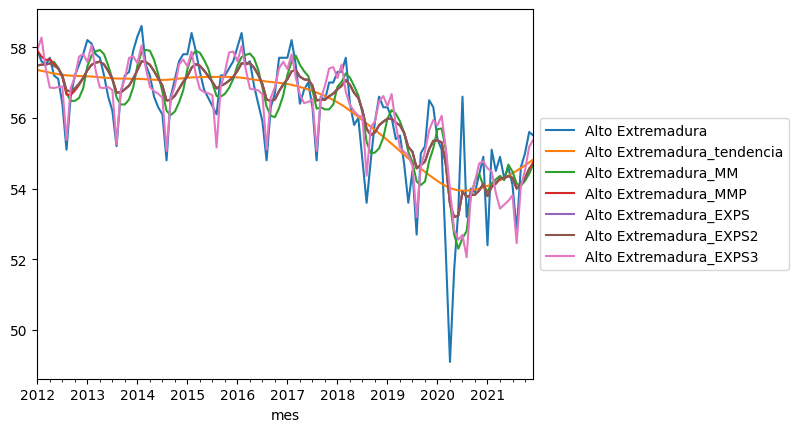

In [35]:
# Las medias móviles ponderadas, EXPS y EXPS2 coinciden
df_train_example[['Alto Extremadura', 
                    'Alto Extremadura_tendencia',
                    'Alto Extremadura_MM',
                    'Alto Extremadura_MMP',
                    'Alto Extremadura_EXPS',
                    'Alto Extremadura_EXPS2',
                    'Alto Extremadura_EXPS3'
                    ]
                ].plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [36]:
test = df_test_example['Alto Extremadura']

test


mes
2022-01-01    55.2
2022-02-01    55.1
2022-03-01    55.8
2022-04-01    53.2
2022-05-01    55.0
2022-06-01    55.0
2022-07-01    53.4
2022-08-01    51.9
2022-09-01    54.0
2022-10-01    54.0
2022-11-01    55.2
2022-12-01    55.3
2023-01-01    55.0
2023-02-01    54.4
Freq: MS, Name: Alto Extremadura, dtype: float64

In [37]:
# Predicción como ejemplo con suavizado triple
model = ExponentialSmoothing(df_train_example['Alto Extremadura'], trend="add", seasonal="add", seasonal_periods=12).fit()

test = df_test_example['Alto Extremadura']
pred = model.forecast(len(test))

pred


2022-01-01    55.317592
2022-02-01    55.667590
2022-03-01    54.937590
2022-04-01    54.367594
2022-05-01    54.187596
2022-06-01    54.144262
2022-07-01    54.110930
2022-08-01    52.697596
2022-09-01    54.227597
2022-10-01    54.577595
2022-11-01    55.147595
2022-12-01    55.267595
2023-01-01    55.064844
2023-02-01    55.414842
Freq: MS, dtype: float64

In [38]:
# Métricas de prueba
print(f'rmse: {mean_squared_error(test, pred, squared=False)}')
print(f'mse: {mean_squared_error(test, pred)}')
print(f'mae: {mean_absolute_error(test,pred)}')
print(f'r2: {r2_score(test, pred)}')
print(f'mape: {mean_absolute_percentage_error(test, pred)}')


rmse: 0.6761342225601906
mse: 0.45715748691707336
mae: 0.5615387806156669
r2: 0.560791787482249
mape: 0.010366114069049456


### Con todas las zonas

In [53]:
size = int(len(df_acoustics)*0.958)
df_train = df_acoustics.iloc[:size].copy()
df_test = df_acoustics.iloc[size:].copy()


In [55]:
# Hay que buscar un modelo que capture mejor la complejidad
r2_dict = dict()
for col in df_train.columns:
    test = df_test[col]
    r2_list = []
    for alpha in np.arange(0.01, 1.01, 0.01).tolist():
        model_simple = SimpleExpSmoothing(df_train[col]).fit(smoothing_level=alpha)
        model_double = ExponentialSmoothing(df_train[col]).fit(smoothing_level=alpha)
        model_triple = ExponentialSmoothing(df_train[col], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=alpha)
        for model, model_name in [[model_simple, 'model_simple'], [model_double, 'model_double'], [model_triple, 'model_triple']]:
            pred = model.forecast(len(test))
            r2 = r2_score(test, pred)
            r2_list.append([r2, model_name, alpha])
    best = sorted(r2_list, reverse=True)[0]
    r2_dict[col] = best

r2_dict


c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide 

{'Alto Extremadura': [0.5448187451203717, 'model_triple', 0.09],
 'Arturo Soria': [0.514376015159125, 'model_triple', 0.48000000000000004],
 'Avda de Moratalaz': [0.5608628221461203, 'model_triple', 0.01],
 'Barajas Pueblo': [0.07649817388519764, 'model_triple', 0.43],
 'Barrio del Pilar': [0.7884438133566095, 'model_triple', 0.49],
 'Campo de las Naciones': [-2.9934766154759984e-07,
  'model_simple',
  0.35000000000000003],
 'Carlos V': [-0.06318449873631438, 'model_simple', 1.0],
 'Casa de Campo': [-0.4078884633575379, 'model_simple', 0.01],
 'Castellana': [0.492191070861024, 'model_triple', 0.04],
 'Cuatro Caminos': [-0.040319147905868435, 'model_simple', 0.04],
 'Cuatro Vientos': [-0.0004033251694832707, 'model_simple', 0.65],
 'El Pardo': [-3.5487788819565935e-05, 'model_simple', 0.23],
 'Embajada': [-0.753786396314841, 'model_triple', 1.0],
 'Ensanche de Vallecas': [0.9671923096133765, 'model_triple', 0.53],
 'Escuelas Aguirre': [0.09541670899027488, 'model_triple', 1.0],
 'Farol

In [56]:
# Se crea un dataframe nuevo de entrenamiento con los datos suavizados para cada zona con el mejor método respectivo
df_train_smoothed = pd.DataFrame({'A' : []})

for key, value in r2_dict.items():
    if value[1] == 'model_simple':
        df_train_smoothed[key] = SimpleExpSmoothing(df_train[key]).fit(smoothing_level=value[2]).fittedvalues
    elif value[1] == 'model_double':
        df_train_smoothed[key] = ExponentialSmoothing(df_train[key]).fit(smoothing_level=value[2]).fittedvalues.shift(-1)
    else:
        df_train_smoothed[key] = ExponentialSmoothing(df_train[key], trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=value[2]).fittedvalues

df_train_smoothed = df_train_smoothed.drop(columns='A')


c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  g = (g - lb) / (ub - lb)
c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\statsmodels\tsa\holtwinters\_smoothers.py:138: RuntimeWarning: divide 

In [57]:
# El dataframe suavizado tiene algunos nulos
df_train_smoothed.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2012-01-01 to 2022-08-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          128 non-null    float64
 1   Arturo Soria              128 non-null    float64
 2   Avda de Moratalaz         128 non-null    float64
 3   Barajas Pueblo            128 non-null    float64
 4   Barrio del Pilar          128 non-null    float64
 5   Campo de las Naciones     128 non-null    float64
 6   Carlos V                  128 non-null    float64
 7   Casa de Campo             128 non-null    float64
 8   Castellana                128 non-null    float64
 9   Cuatro Caminos            128 non-null    float64
 10  Cuatro Vientos            128 non-null    float64
 11  El Pardo                  128 non-null    float64
 12  Embajada                  128 non-null    float64
 13  Ensanche de Vallecas      128 non-nul

In [58]:
# Se interpolan como antes
df_train_smoothed = df_train_smoothed.apply(lambda x: x.interpolate(method='linear'))

df_train_smoothed.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2012-01-01 to 2022-08-01
Freq: MS
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Alto Extremadura          128 non-null    float64
 1   Arturo Soria              128 non-null    float64
 2   Avda de Moratalaz         128 non-null    float64
 3   Barajas Pueblo            128 non-null    float64
 4   Barrio del Pilar          128 non-null    float64
 5   Campo de las Naciones     128 non-null    float64
 6   Carlos V                  128 non-null    float64
 7   Casa de Campo             128 non-null    float64
 8   Castellana                128 non-null    float64
 9   Cuatro Caminos            128 non-null    float64
 10  Cuatro Vientos            128 non-null    float64
 11  El Pardo                  128 non-null    float64
 12  Embajada                  128 non-null    float64
 13  Ensanche de Vallecas      128 non-nul

### Guardado df_train_smoothed y df_test

In [59]:
df_train_smoothed.to_csv('data/processed/train_smoothed.csv')
df_test.to_csv('data/processed/test.csv')

df_train_smoothed.head()


,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,58.065408,59.497780,58.942969,54.243855,59.699623,57.329297,67.8,45.412149,62.674648,60.173189,...,64.899907,58.209732,62.907579,66.491786,55.550157,61.799964,52.075631,50.945875,54.340066,52.200027
2012-02-01,58.359604,60.076661,59.144539,54.526675,59.952358,57.389043,67.8,45.423028,63.063145,60.202262,...,64.859519,58.859827,62.924503,66.920724,55.391732,61.963662,52.053698,51.013690,54.614772,52.545486
2012-03-01,57.691198,58.942767,58.632006,54.503665,59.027128,57.602878,67.8,45.443797,62.333180,60.258171,...,63.959520,58.250806,62.936258,65.456581,53.912464,61.363670,51.980126,51.095666,53.865966,51.963664
2012-04-01,56.919465,58.115710,58.455950,53.639909,58.617336,57.531871,67.8,45.471359,61.469234,60.279845,...,63.841346,57.835576,62.951896,65.216366,53.014737,61.236328,51.956889,50.745573,53.460989,52.754572
2012-05-01,56.989721,58.076518,58.265489,52.862261,58.757814,57.205716,67.8,45.482646,61.021725,60.280651,...,63.427544,58.663635,62.961377,65.763058,52.889826,61.499992,52.143391,50.593521,53.877337,54.009116


In [60]:
df_train_smoothed = pd.read_csv('data/processed/train_smoothed.csv', parse_dates=['mes'], index_col='mes')
df_test = pd.read_csv('data/processed/test.csv', parse_dates=['mes'], index_col='mes')

df_train_smoothed = df_train_smoothed.asfreq('MS')
df_test = df_test.asfreq('MS')

df_train_smoothed.head()


,Alto Extremadura,Arturo Soria,Avda de Moratalaz,Barajas Pueblo,Barrio del Pilar,Campo de las Naciones,Carlos V,Casa de Campo,Castellana,Cuatro Caminos,...,Plaza de España,Plaza del Carmen,Pza de Castilla,Ramón y Cajal,Sanchinarro,Santa Eugenia,Tres Olivos,Urbanización Embajada II,Vallecas,Villaverde
mes,,,,,,,,,,,,,,,,,,,,,
2012-01-01,58.065408,59.497780,58.942969,54.243855,59.699623,57.329297,67.8,45.412149,62.674648,60.173189,...,64.899907,58.209732,62.907579,66.491786,55.550157,61.799964,52.075631,50.945875,54.340066,52.200027
2012-02-01,58.359604,60.076661,59.144539,54.526675,59.952358,57.389043,67.8,45.423028,63.063145,60.202262,...,64.859519,58.859827,62.924503,66.920724,55.391732,61.963662,52.053698,51.013690,54.614772,52.545486
2012-03-01,57.691198,58.942767,58.632006,54.503665,59.027128,57.602878,67.8,45.443797,62.333180,60.258171,...,63.959520,58.250806,62.936258,65.456581,53.912464,61.363670,51.980126,51.095666,53.865966,51.963664
2012-04-01,56.919465,58.115710,58.455950,53.639909,58.617336,57.531871,67.8,45.471359,61.469234,60.279845,...,63.841346,57.835576,62.951896,65.216366,53.014737,61.236328,51.956889,50.745573,53.460989,52.754572
2012-05-01,56.989721,58.076518,58.265489,52.862261,58.757814,57.205716,67.8,45.482646,61.021725,60.280651,...,63.427544,58.663635,62.961377,65.763058,52.889826,61.499992,52.143391,50.593521,53.877337,54.009116


# Modelaje

## ARIMA

### Entrenamiento

In [62]:
# Se guardan los mejores hiperparámetros, el modelo, la r2 y el mae de cada zona en un diccionario
zone_dict = dict()
for col in df_train_smoothed.columns:
    model = auto_arima(df_train_smoothed[col], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
    best_order = model.order
    best_seasonal_order = model.seasonal_order
    pred = model.predict(start=len(df_train_smoothed), n_periods=len(df_test))
    test = df_test[col]
    r2 = r2_score(test, pred)
    mae = mean_absolute_error(test, pred)
    zone_dict[col] = {'params': best_order + best_seasonal_order,
                      'model': model,
                      'r2': r2,
                      'mae': mae,
                      'pred': pred
                      }


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-255.844, Time=3.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-174.192, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-230.981, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-245.594, Time=0.46 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=-257.841, Time=1.55 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=-222.111, Time=0.57 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=-255.844, Time=2.83 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-240.773, Time=0.98 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=-254.013, Time=3.56 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-258.320, Time=1.42 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-220.028, Time=0.35 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-256.320, Time=1.63 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=-256.320, Time=2.03 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-239.059, Time=0.62 sec
 ARIMA(1,1,2)(1,1,2

In [64]:
# Las métricas son las siguientes
zone_dict


{'Alto Extremadura': {'params': (0, 1, 2, 0, 1, 1, 12),
  'model': ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
        suppress_warnings=True, with_intercept=False),
  'r2': 0.5419437259357852,
  'mae': 0.3323858460606104,
  'pred': 2022-09-01    53.913642
  2022-10-01    54.194831
  2022-11-01    54.768831
  2022-12-01    54.900059
  2023-01-01    54.667702
  2023-02-01    54.949719
  Freq: MS, dtype: float64},
 'Arturo Soria': {'params': (2, 1, 1, 1, 0, 2, 12),
  'model': ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
        suppress_warnings=True, with_intercept=False),
  'r2': -1.0564268281072375,
  'mae': 1.0675066253243841,
  'pred': 2022-09-01    52.936608
  2022-10-01    53.882815
  2022-11-01    54.493039
  2022-12-01    54.690068
  2023-01-01    54.257593
  2023-02-01    54.034837
  Freq: MS, dtype: float64},
 'Avda de Moratalaz': {'params': (2, 1, 2, 0, 1, 2, 12),
  'model': ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_or

### Predicción

In [65]:
# ESTA PARTE ESTA ROTA; HABRÍA QUE SUAVIZAR Y PASAR EL DF ENTERO
# NO ES NECESARIO, YA QUE SE VE CLARO QUE LAS PREDICCIONES SON PEORES QUE CON ML
# Se guardan las predicciones hasta abril de 2024 en un nuevo dataframe
# Se cogen solo aquellas zonas donde la r2 es superior a 0, es decir, que el modelo predice mejor que la media, lo que permite sacarle partido
df_predictions = pd.DataFrame({'A' : []})
for key, value in zone_dict.items():
    if value['r2'] > 0.0 and value['mae'] < 1.0:
        df_predictions[key] = value['model'].predict(start=len(df_train_smoothed), n_periods=len(df_test) * 2)

df_predictions = df_predictions.drop(columns='A')

df_predictions.head()


,Alto Extremadura,Avda de Moratalaz,Castellana,Farolillo,Gregorio Marañón,Méndez Álvaro,Plaza del Carmen,Sanchinarro,Vallecas
2022-09-01,53.913642,55.068658,56.776358,49.602161,64.545427,48.696124,58.005292,52.221608,52.873189
2022-10-01,54.194831,55.676942,57.313478,49.268253,65.153255,48.213937,58.020892,53.498647,53.031599
2022-11-01,54.768831,55.926336,57.838895,49.159883,65.561428,47.941151,57.808335,54.378638,53.397327
2022-12-01,54.900059,56.016242,57.904417,49.265297,65.573518,47.710599,57.891296,54.519791,53.130485
2023-01-01,54.667702,55.770421,57.691577,48.808926,65.118748,47.744415,56.933935,54.264799,52.706189


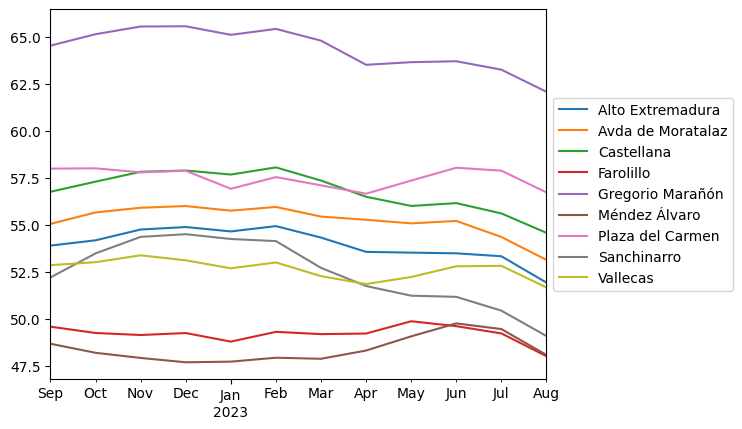

In [66]:
# Se visualizan las predicciones
df_predictions.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [67]:
# Se imprimen las predicciones para 2024 en base a los estándares de la OMS
print('Estas son las predicciones de contaminación acústica para la entrada de 2024, según el varemo de la OMS:')
for col in df_predictions:
    if (df_predictions[col].loc['2024-01-01'] > 55.0) & (df_predictions[col].loc['2024-01-01'] < 60.0):
        print(f'- La contaminación de la zona de {col} causará molestias en las personas ({round(df_predictions[col].loc["2024-01-01"], 2)} dBA la mayoría del tiempo).')
    elif (df_predictions[col].loc['2024-01-01'] > 60.0) & (df_predictions[col].loc['2024-01-01'] < 65.0):
        print(f'- La contaminación de la zona de {col} causará molestias serias en las personas ({round(df_predictions[col].loc["2024-01-01"], 2)} dBA la mayoría del tiempo).')
    elif df_predictions[col].loc['2024-01-01'] > 65.0:
        print(f'- La contaminación de la zona de {col} producirá transtornos de comportamiento ({round(df_predictions[col].loc["2024-01-01"], 2)} dBA la mayoría del tiempo).')
    else:
        print(f'- La contaminación de la zona de {col} no será grave ({round(df_predictions[col].loc["2024-01-01"], 2)} dBA la mayoría del tiempo).')


Estas son las predicciones de contaminación acústica para la entrada de 2024, según el varemo de la OMS:


KeyError: '2024-01-01'

## ARIMA con exógenos

### Entrenamiento

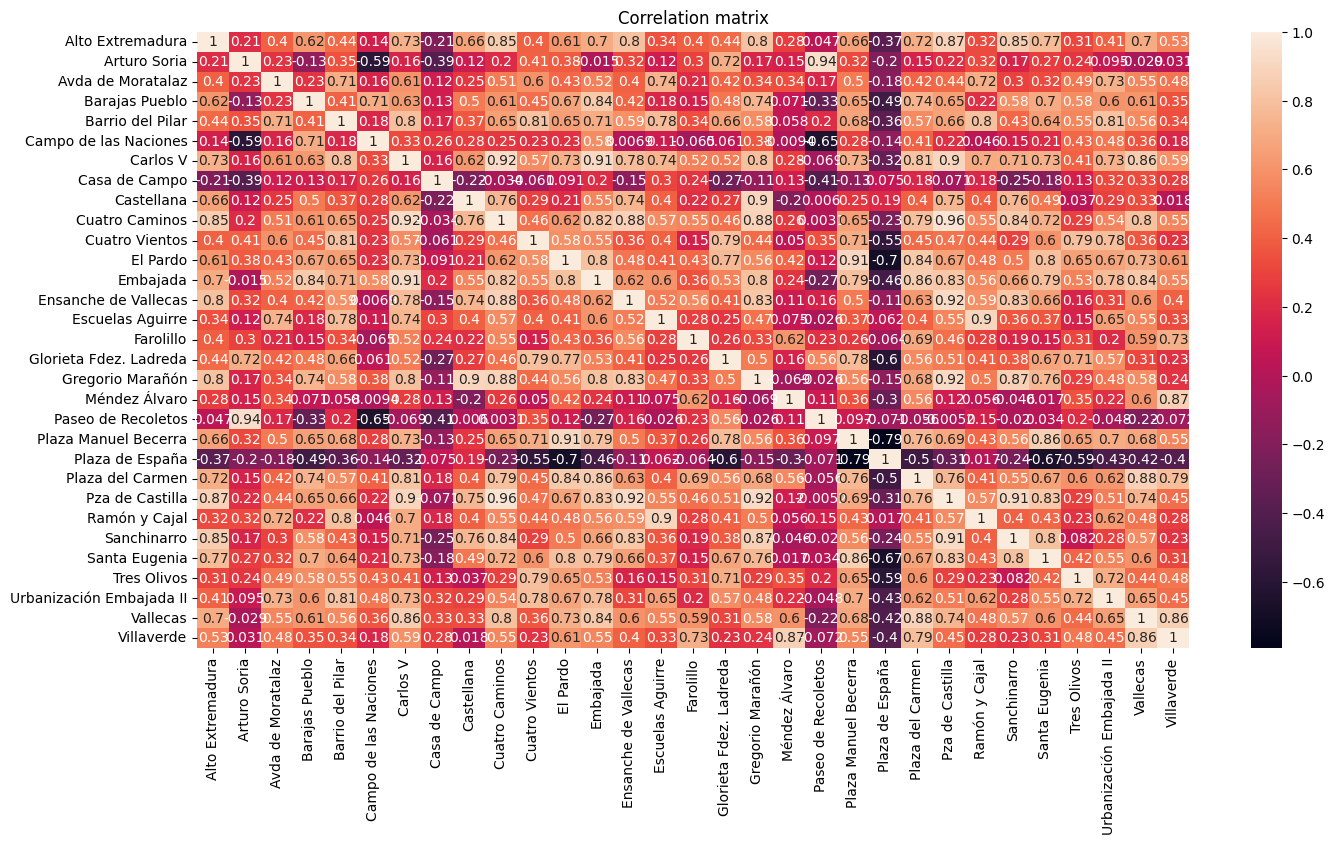

In [ ]:
# Se echa un vistazo a las correlaciones. Las hay significativas
plt.rc("figure", figsize=(16, 8))

corr = df_train_smoothed.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [ ]:
exog_cols = []
zone_dict = {}

for col in df_train_smoothed.columns:
    # Seleccionar variables exógenas
    corr = df_train_smoothed.corrwith(df_train_smoothed[col])
    relevant_cols = corr[(corr > 0.5)]
    if len(relevant_cols) > 0:
        exog_cols = list(relevant_cols.index)
    else:
        exog_cols = None

    # Entrenar modelo y hacer predicción
    model = auto_arima(df_train_smoothed[col], exogenous=df_train_smoothed[exog_cols], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
    best_order = model.order
    best_seasonal_order = model.seasonal_order
    pred = model.predict(start=len(df_train_smoothed), n_periods=len(df_test))
    test = df_test[col]
    r2 = r2_score(test, pred)
    mae = mean_absolute_error(test, pred)

    # Guardar resultados en diccionario
    zone_dict[col] = {'params': best_order + best_seasonal_order,
                      'model': model,
                      'r2': r2,
                      'mae': mae,
                      'exog_cols': exog_cols}


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=42.620, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=32.055, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=32.470, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=56.574, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=31.365, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=32.063, Time=0.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=34.043, Time=1.01 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=25.180, Time=0.10 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=22.840, Time=0.51 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=19.865, Time=0.71 s

In [ ]:
zone_dict

{'Alto Extremadura': {'params': (3, 0, 0, 1, 1, 0, 12),
  'model': ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
        suppress_warnings=True),
  'r2': -21.42317292414506,
  'mae': 1.5558066615464696,
  'exog_cols': ['Alto Extremadura',
   'Barajas Pueblo',
   'Carlos V',
   'Castellana',
   'Cuatro Caminos',
   'El Pardo',
   'Embajada',
   'Ensanche de Vallecas',
   'Gregorio Marañón',
   'Plaza Manuel Becerra',
   'Plaza del Carmen',
   'Pza de Castilla',
   'Sanchinarro',
   'Santa Eugenia',
   'Vallecas',
   'Villaverde']},
 'Arturo Soria': {'params': (2, 0, 0, 0, 0, 0, 12),
  'model': ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
        suppress_warnings=True),
  'r2': -1.4559434298710694,
  'mae': 0.8070476240020508,
  'exog_cols': ['Arturo Soria',
   'Glorieta Fdez. Ladreda',
   'Paseo de Recoletos']},
 'Avda de Moratalaz': {'params': (0, 0, 1, 0, 0, 0, 12),
  'model': ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 

### Predicción

In [ ]:
# Se guardan las predicciones hasta abril de 2024 en un nuevo dataframe
# Se cogen solo aquellas zonas donde la r2 es superior a 0, es decir, que el modelo predice mejor que la media, lo que permite sacarle partido
df_predictions = pd.DataFrame({'A' : []})
for key, value in zone_dict.items():
    if value['r2'] > 0.0 and value['mae'] < 1.0:
        df_predictions[key] = value['model'].predict(start=len(df_train_smoothed), n_periods=len(df_test) * 2)

df_predictions = df_predictions.drop(columns='A')

df_predictions.head()


,Barajas Pueblo
2022-11-01,53.668392
2022-12-01,52.935982
2023-01-01,53.711651
2023-02-01,53.381778
2023-03-01,52.717115
